In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
all_dummies_scaled = pd.read_csv("preprocessed_data.csv")
all_data = pd.read_csv("all_data.csv")

In [3]:
X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

# Model Building (Baseline Validation Performance)¶

Before going further, I like to see how various different models perform with default parameters. I tried the following models using 5 fold cross validation to get a baseline. With a validation set basline, we can see how much tuning improves each of the models. Just because a model has a high basline on this validation set doesn't mean that it will actually do better on the eventual test set.

## Naive Bayes (75.3%)
## Logistic Regression (82.0%)
## Decision Tree (76.2%)
## K Nearest Neighbor (50.2%)
## Random Forest (81.5%)
## Support Vector Classifier (61.7%)
## Soft Voting Classifier - All Models (77.6%)

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [5]:
#I usually use Naive Bayes as a baseline for my classification tasks 

gnb = GaussianNB()
cv = cross_val_score(gnb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.70224719 0.73595506 0.78089888 0.76404494 0.77966102]
0.7525614168729766


In [6]:
lr = LogisticRegression( max_iter=1000)
cv = cross_val_score(lr,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.81460674 0.80898876 0.80337079 0.82022472 0.85310734]
0.8200596711737447


In [7]:
dt = DecisionTreeClassifier()
cv = cross_val_score(dt,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.62921348 0.79775281 0.80898876 0.78089888 0.71751412]
0.746873611375611


In [8]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.61797753 0.38202247 0.46067416 0.43258427 0.61581921]
0.5018155272011681


In [9]:
rf = RandomForestClassifier()
cv = cross_val_score(rf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.79775281 0.79775281 0.85393258 0.79213483 0.83615819]
0.815546245159652


In [10]:
svc = SVC(probability=True)
cv = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.61797753 0.61797753 0.61797753 0.61797753 0.61581921]
0.6175458642798197


In [11]:
#Voting classifier takes all of the inputs and averages the results. For a "hard" voting classifier each classifier gets 1 vote "yes" or "no" and the result is just a popular vote. For this, you generally want odd numbers
#A "soft" classifier averages the confidence of each of the models. If a the average confidence is > 50% that it is a 1 it will be counted as such


voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),
                                            ('svc',svc)], voting = 'soft')
cv = cross_val_score(voting_clf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.7247191  0.78089888 0.79213483 0.78089888 0.79661017]
0.7750523709769568


# Model Tuned Performance

After getting the baselines, let's see if we can improve on the indivdual model results!I mainly used grid search to tune the models. I also used Randomized Search for the Random Forest  to simplify testing time.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [13]:
#simple performance reporting function

def clf_performance(classifier,model_name):
    print('Model Name : ',model_name)
    print("Best Score : " + str(classifier.best_score_))
    print("Best Parameters : " + str(classifier.best_params_))

In [14]:
lr = LogisticRegression()
param_grid = {'penalty': ['l1','l2'],
              'max_iter' : [1000],
              'C' : np.logspace(-4,4,20),
              'solver' : ['liblinear'] 
             }
clf_lr = GridSearchCV(lr,param_grid=param_grid)
best_clf_lr = clf_lr.fit(X_train_scaled,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Model Name :  Logistic Regression
Best Score : 0.8256903446962482
Best Parameters : {'C': 1.623776739188721, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}


In [15]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7],
              'weights' : ['uniform','distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]   
}
clf_knn = GridSearchCV(knn,param_grid=param_grid)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'K Neighbors Classifier')

Model Name :  K Neighbors Classifier
Best Score : 0.5332762013584713
Best Parameters : {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


In [16]:
svc = SVC()
param_grid = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],'C': [.1, 1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
              {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}  
             ]
clf_svc = GridSearchCV(svc,param_grid=param_grid)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'K Neighbors Classifier')

Model Name :  K Neighbors Classifier
Best Score : 0.8211705706849489
Best Parameters : {'C': 0.1, 'kernel': 'linear'}


In [17]:
#Because the total feature space is so large, I used a randomized search to narrow down the paramters for the model. I took the best model from this and did a more granular search 

rf = RandomForestClassifier()
param_grid =  {'n_estimators': [100,500,1000], 
               'bootstrap': [True,False],
               'max_depth': [3,5,10,20,50,75,100,None],
               'max_features': ['auto','sqrt'],
               'min_samples_leaf': [1,2,4,10],
               'min_samples_split': [2,5,10]
              }
clf_rf_rnd = RandomizedSearchCV(rf,param_distributions = param_grid)
best_clf_rf_rnd = clf_rf_rnd.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf_rnd,'Random Forest Classifier')

Model Name :  Random Forest Classifier
Best Score : 0.8301783787215132
Best Parameters : {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [18]:
rf = RandomForestClassifier()
param_grid =  {'n_estimators': [100,150], 
               'bootstrap': [True],
               'max_depth': [50,75,100,None],
               'max_features': ['auto'],
               'min_samples_leaf': [1,2],
               'min_samples_split': [5,10]
              }
clf_rf = GridSearchCV(rf,param_grid = param_grid)
best_clf_rf = clf_rf.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf,'Random Forest Classifier')

Model Name :  Random Forest Classifier
Best Score : 0.8313019742271314
Best Parameters : {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


<AxesSubplot:>

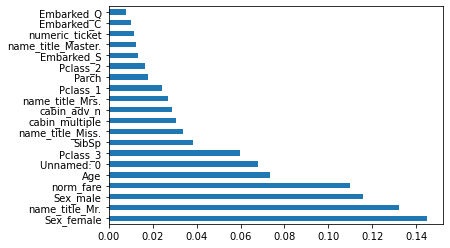

In [19]:
best_rf = best_clf_rf.best_estimator_.fit(X_train_scaled,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')


# Model Additional Ensemble Approaches¶

1) Experimented with a hard voting classifier of three estimators (KNN, SVM, RF) 

2) Experimented with a soft voting classifier of three estimators (KNN, SVM, RF) 

3) Experimented with soft voting on all estimators 

4) Experimented with soft voting on all estimators 

In [23]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf.best_estimator_


voting_clf_hard = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'soft') 
voting_clf_all = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('lr', best_lr)], voting = 'soft') 


print('voting_clf_hard :',cross_val_score(voting_clf_hard,X_train_scaled,y_train,cv=5))
print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,X_train_scaled,y_train,cv=5).mean())

print('voting_clf_soft :',cross_val_score(voting_clf_soft,X_train_scaled,y_train,cv=5))
print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,X_train_scaled,y_train,cv=5).mean())

print('voting_clf_all :',cross_val_score(voting_clf_all,X_train_scaled,y_train,cv=5))
print('voting_clf_all mean :',cross_val_score(voting_clf_all,X_train_scaled,y_train,cv=5).mean())



voting_clf_hard : [0.80337079 0.81460674 0.8258427  0.79213483 0.85310734]
voting_clf_hard mean : 0.8189360756681268


C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\ensemble\_voting.py", line 309, in predict
    maj = np.argmax(self.predi

voting_clf_soft : [nan nan nan nan nan]


C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\ensemble\_voting.py", line 309, in predict
    maj = np.argmax(self.predi

voting_clf_soft mean : nan


C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\ensemble\_voting.py", line 309, in predict
    maj = np.argmax(self.predi

voting_clf_all : [nan nan nan nan nan]


C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\ensemble\_voting.py", line 309, in predict
    maj = np.argmax(self.predi

voting_clf_all mean : nan


C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\sonu7\anaconda3\lib\site-packages\sklearn\ensemble\_voting.py", line 309, in predict
    maj = np.argmax(self.predi